# PROYECTO FINAL --- DARIO OVIEDO RUEDA

## 1. Tema: Comparativa entre las marcas del Holy Trinity 

#### Este proyecto consiste en evaluar las diferencias en las 3 compañias relojares identificadas como "Santísima Trinidad" (Holy Trinity): Audemars Piguet, Patek Philippe y Vacheron Constantin.

#### Esta evaluación esta basada en la pagina de EBay y consiste en los siguientes criterios:
#### - Cantidad disponible de cada uno
#### - Rango de precios por marca
#### - Precio promedio por marca

## 2. Entorno Virtual

### 2.1. Importación de librerias

In [113]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import csv
import datetime
import locale
from fastapi import FastAPI
from pydantic import BaseModel
locale.setlocale(locale.LC_ALL, '')

'English_United States.1252'

### 2.2. Creación de funciones requeridas

#### 2.2.1 Funciones de Web Scraping

In [76]:
data = []
#def obtener_html(url):
#    response = requests.get(url)
#    return response.text

#def analizar_html(html):
#    return BeautifulSoup(html, 'html.parser')

def obtener_analizar(url):
    response = requests.get(url)
    return BeautifulSoup(response.text, 'html.parser')


def procesar_html(soup):
    titulos = []
    precios = []
    precios_envio = []
    skus = []
    marca = []
    sellers = []

    titulo_items = soup.find_all('div', "s-item__info clearfix")
    for item in titulo_items:
        titulo = item.a.text.strip() 
        indece = titulo.find("Open")
        titulo = titulo[0:indece]
        str_tittle = titulo.lower()
        if str_tittle.find("audemars") > -1:
            marca.append("Audemars Piguet")
        elif str_tittle.find("patek") > -1:
            marca.append("Patek Philippe")
        elif str_tittle.find("vacheron") > -1:
            marca.append("Vacheron Constantin")
        else:
            marca.append("Unknown")
        
        titulos.append(titulo)

    precios_items = soup.find_all('span', class_="s-item__price")
    for item in precios_items:
        precio = item.text.strip()
        ind_precio = precio.find("$")
        precio = precio[ind_precio+1:]
        precio = precio.replace(u'\xa0', '')
        precio = float(precio.strip())
        precios.append(precio)

    #seller_items = soup.find_all('div', class_="s-seller-feedback")
    #print(seller_items)
    #for item in seller_items:
    #    print("Ahi va")
    #    print(item)
    #    seller = item.text.strip()
    #    print(seller)


    #precio_envio_items = soup.find_all("span", class_={"deliveryvalue", "deliverytextfree"})
    #for item in precio_envio_items:
    #    precio_envio = item.text
    #    precios_envio.append(precio_envio)

    #sku_items = soup.find_all("div", class_="emproduct_right_artnum")
    #for item in sku_items:
    #    sku = item.text.strip()
    #    skus.append(sku.lstrip("SKU: "))


    #min_length = min(len(titulos), len(skus), len(precios), len(precios_envio))
    min_length = min(len(titulos), len(precios))

    for i in range(min_length):
        data.append({
            "Marca": marca[i] if i < len(marca) else None,
            "Descripcion": titulos[i] if i < len(titulos) else None,
            "Precio": precios[i] if i < len(precios) else None,
           # "Sku": skus[i] if i < len(skus) else None,
           # "Precio": precios[i] if i < len(precios) else None,
           # "Precio Envio": precios_envio[i] if i < len(precios_envio) else None,
        })
    
def informacion(direccion, paginas):
    sopa = obtener_analizar(direccion)
    procesar_html(sopa)
    data.pop(0)
    if paginas > 1:
        for i in range(paginas):
            direccion_nueva = direccion + "&_pgn=" + str(i+2)
            sopa = obtener_analizar(direccion)
            procesar_html(sopa)


## 3. Adquisicion de datos

### 3.1. Interface con el usuario para conocer la pagina web de Ebay y la cantidad de paginas a usar

In [77]:
paginas = int(input("Cantidad de páginas? : "))
direccion = input("Página web: ")

### 3.2. Procesamiento de la informacion

In [78]:
informacion(direccion, paginas)

### 3.3. Generacion del Dataframe

In [79]:
df = pd.DataFrame(data)

In [80]:
df

,Marca,Descripcion,Precio
0,Vacheron Constantin,Reloj para hombre Vacheron & Constantin oro 18...,64099.52
1,Patek Philippe,Patek Philippe Nautilus 5712G esfera gris rese...,2090723.90
2,Patek Philippe,Anuncio nuevoReloj para hombre Patek Philippe ...,1170999.93
3,Patek Philippe,"Reloj de bolsillo para hombre PATEK, PHILIPPE ...",49215.94
4,Audemars Piguet,Sin usar Audemars Piguet Royal Oak 41 mm cronó...,6370918.47
...,...,...,...
819,Patek Philippe,Patek Philippe | Nautilus 5712/1a | acero | es...,862936.04
820,Audemars Piguet,Reloj para hombre Audemars Piguet Royal Oak gris,1618207.35
821,Patek Philippe,Patek Philippe Nautilus 5711 esfera verde acer...,1527391.22
822,Patek Philippe,Anuncio nuevoPatek PHILIPPE CALATRAVA 3588/2 p...,5854999.66


### 3.4. Limpieza

#### Debido a que Ebay promociona productos similares que no pertenecen al Holy Trinity, es necesario elimiar los renglones que no son de esas marcas

In [81]:
df = df[df['Marca'] != 'Unknown']

In [82]:
len(df[df['Marca'] == 'Patek Philippe'])

407

In [83]:
len(df[df['Marca'] == 'Audemars Piguet'])

143

In [84]:
len(df[df['Marca'] == 'Vacheron Constantin'])

242

In [85]:
len(df[df['Marca'] == 'Unknown'])

0

In [86]:
fecha_actual = datetime.datetime.now().strftime("%d-%m-%Y")

df.to_csv(f"dataset/web scraping/Relojes-{fecha_actual}.csv", index=False)

## 4. Analisis exploratorio de datos

### 4.1 Grafica de barras mostrando la cantidad de unidades disponibles por marca

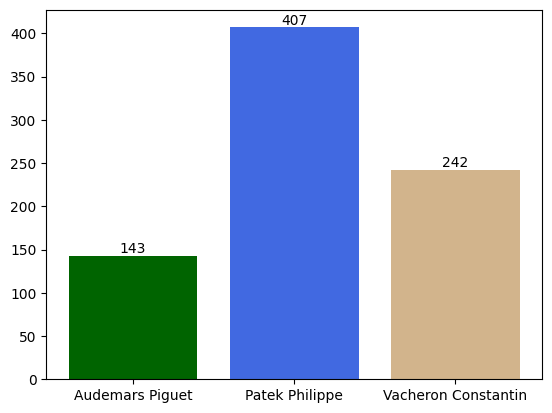

In [87]:
fig, ax = plt.subplots()
x = np.array(["Audemars Piguet", "Patek Philippe", "Vacheron Constantin"])
values_array = [len(df[df['Marca'] == 'Audemars Piguet']), len(df[df['Marca'] == 'Patek Philippe']), len(df[df['Marca'] == 'Vacheron Constantin'])]
y = values_array
values_bar = ax.bar(x, y)
ax.bar_label(values_bar)
plt.bar(x, y, color = ['darkgreen', 'royalblue', 'tan'])
plt.show()

### 4.2 Grafica de Pastel mostrando las proporciones de cada uno en cuanto a las unidades disponibles en el mercado

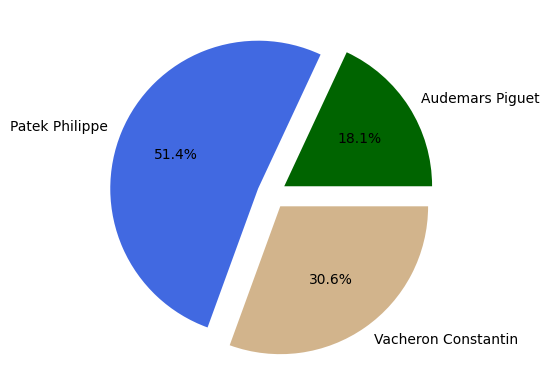

In [88]:
labels = "Audemars Piguet", "Patek Philippe", "Vacheron Constantin"
explode = (0.1, 0.1, 0.1)
fig1, ax1 = plt.subplots()
ax1.pie(y, explode = explode, labels=labels, autopct='%1.1f%%', colors = ['darkgreen', 'royalblue', 'tan'])
plt.show()


### 4.3 Grafica de Barras mostrando el promedio del costo por reloj expresado en Pesos

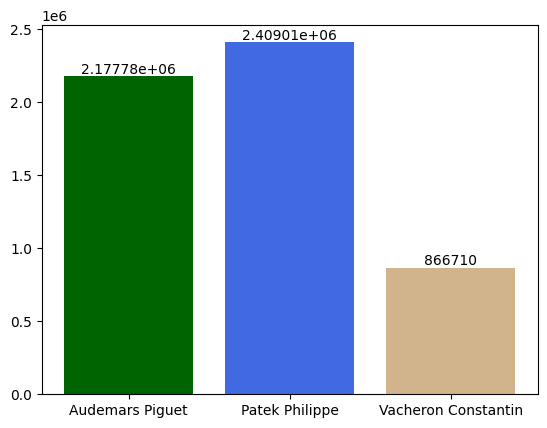

In [89]:
preciototal_a = df.loc[df['Marca'] == 'Audemars Piguet', 'Precio'].sum()
preciototal_p = df.loc[df['Marca'] == 'Patek Philippe', 'Precio'].sum()
preciototal_v = df.loc[df['Marca'] == 'Vacheron Constantin', 'Precio'].sum()
cantidadtotal_a = len(df[df['Marca'] == 'Audemars Piguet'])
cantidadtotal_p = len(df[df['Marca'] == 'Patek Philippe'])
cantidadtotal_v = len(df[df['Marca'] == 'Vacheron Constantin'])

promedio_a = preciototal_a / cantidadtotal_a
promedio_p = preciototal_p / cantidadtotal_p
promedio_v = preciototal_v / cantidadtotal_v

currency_a = '${:,.2f}'.format(promedio_a)
currency_p = '${:,.2f}'.format(promedio_p)
currency_v = '${:,.2f}'.format(promedio_v)

fig, ax = plt.subplots()
x = np.array(["Audemars Piguet", "Patek Philippe", "Vacheron Constantin"])
#values_array = ['${:,.2f}'.format(promedio_a), '${:,.2f}'.format(promedio_p), '${:,.2f}'.format(promedio_v)]
values_array = [promedio_a, promedio_p, promedio_v]
values_array_currency = [currency_a, currency_p, currency_v]
y = values_array
values_bar = ax.bar(x, y)
ax.bar_label(values_bar)
plt.bar(x, y, color = ['darkgreen', 'royalblue', 'tan'])
plt.show()

In [90]:
#locale.setlocale(locale.LC_ALL, '')


pv = '{:n}'.format(promedio_v)
pa = '{:n}'.format(promedio_a)
pp = '{:n}'.format(promedio_p)

print(type(promedio_a))

print(pv)
print(pa)
print(pp)

<class 'numpy.float64'>
866,710
2.17778e+06
2.40901e+06


## 5. Base de datos

### 5.1. Creacion

In [109]:
def create_watch_table():
    conn = sqlite3.connect("watches.db")
    cursor = conn.cursor()

    cursor.execute("""CREATE TABLE watch(
        id INTEGER PRIMARY KEY,
        marca TEXT NOT NULL,
        descripcion TEXT NOT NULL,
        precio FLOAT NOT NULL
        )""")
    
    conn.commit()
    conn.close()

### 5.2. Leer CSV

In [96]:
def read_csv(csv_file):
    with open(csv_file, newline='') as file:
        reader = csv.DictReader(file)
        data = [row for row in reader]
    return data

### 5.3. Insertar en Base de Datos

In [106]:
def insertar_data(data):
    conn = sqlite3.connect("watches.db")
    cursor = conn.cursor()
    
    for row in data:
        cursor.execute("""
            INSERT INTO watch (marca, descripcion, precio)
            VALUES (?, ?, ?)
        """, (row["Marca"], row["Descripcion"], float(row["Precio"])))

    conn.commit()
    conn.close()

In [ ]:
if __name__ == "__main__":
    csv_file = "C:\\proyecto-final-python-3\\Relojes-15-08-2023.csv"
    data_to_insert = read_csv(csv_file)
    insertar_data(data_to_insert)

if __name__ == "__main__":
    create_watch_table()

## 6. API

In [114]:
class Item(BaseModel):
    marca: str
    descripcion: str
    precio: float

app = FastAPI()

In [ ]:
@app.post("/agregar_elemento/")
async def agregar_elemento(item: Item):
    conn = sqlite3.connect("watches.db")
    cursor = conn.cursor()
    cursor.execute("INSERT INTO watch (marca, descripcion, precio) VALUES (?, ?, ?)", (item.marca, item, descripcion, item.precio))
    conn.commit()
    conn.close()
    return {"mensaje": "Datos agregados"}

In [ ]:
@app.get("/leer_elementos/")
async def leer_elementos():
    conn = sqlite3.connect("watches.db")
    cursor = conn.cursor()
    cursor.execute("SELECT marca, descripcion, precio FROM watch")
    resultados = cursor.fetchall()
    conn.close()
    if resultados:
        return [{"marca": resultado[0], "descripcion": resultado[1], "precio": resultado[2]} for resultado in resultados]
    else:
        return{"mensaje": "No hay datos en la DB"}